<a href="https://colab.research.google.com/github/Andrei-WongE/ML_sandbox/blob/origin/Class_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting-up GPU

In [33]:
#Need to first set up Colab’s runtime environment to use GPUs or TPUs instead of CPUs.
# select “Change runtime type” under “Runtime” from Colab’s menu bar.

import tensorflow as tf

device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))


Found GPU at: /device:GPU:0


CONVOLUTIONAL NEURAL NETWORK WITH KERAS

In [15]:
# plot ad hoc MNIST instances
import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [16]:
# load (downloaded if needed) the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

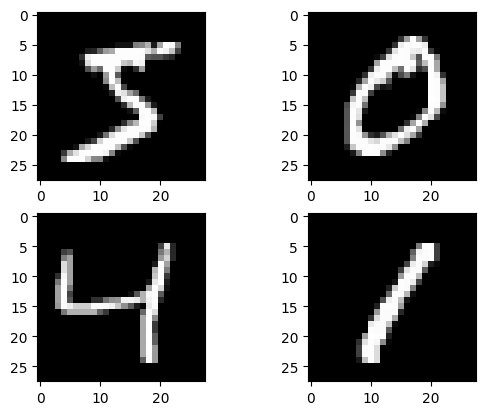

In [17]:
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(x_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(x_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(x_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(x_train[3], cmap=plt.get_cmap('gray'))

Let us import other classes and functions needed

In [18]:
# to see versions, using random seed
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [19]:
# fix random seed for reproducibility
import numpy as np
np.random.seed(7)

Let us use 𝑣𝑒𝑟𝑠𝑖𝑜𝑛 functions to see the versions of Python, TensorFlow and Keras

In [20]:
# print
print('Python version : ', sys.version)
print('TensorFlow version : ', tf.__version__)
print('Keras version : ', keras.__version__)

Python version :  3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
TensorFlow version :  2.15.0
Keras version :  2.15.0


As we already loaded the MNIST dataset, we now just reshape it so that it is suitable for use training a CNN. In Keras, the layers used for two-dimensional convolutions (Conv2D) expect pixel
values with the dimensions `[height][width][channels]`.

In [21]:
img_rows = 28
img_cols = 28 #here we are stating that our input are a set of 28x28 grayscale images.

#the pixel dimension is set to 1 since there is just one channel representing the
# intensity of gray (we will use this piece of code later when defining our CNN)
input_shape = (img_rows, img_cols, 1)

# reshape to be [samples][height][width][channels]
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1) #reshaping
#(samples, 28, 28) to (# samples, 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

In [22]:
# normalise inputs from 0-255 to 0-1
#please note that here we are not talking about the standard normalisation!!!!!!
# process (mean zero, sd 1)
#in the context of pixel values, normalisation refers to change the range between 0 and
#1. We divide by 255 because our MINST database range goes from 0 to 255.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [23]:
# one hot encode outputs
# We need to do this because our CNN needs to learn how to classify images (this is a
# classification task)
#Also, the output layer uses softmax function to convert output values into probabilities
#and it expects the data to be in a one hot encoded.
#furthermore if we leave the data (numbers between 0 an 9) raw, the neuron might
#interpret the labels as ordinal, implying an inherent order among digits.
#please note that the hot encoding it is applied to the target variable ONLY
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [24]:
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [25]:
model = Sequential()

#32 kernels (or filters) in the convolutional layer; 1x1 pixel for the stride; padding =
# same means padding with zero the image using so that the output has the same size of the
#input
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding= "same", activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#activation = relu (rectified linear unit instead of sigmoid function)
#input shape was defined before and we are calling it now
model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) #define the layers to drop out to prevent overfitting
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        8256      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 3136)             

Compiling and fitting the model. The CNN is fit over 12 epochs with a batch size of 128 as defined
above.

In [28]:
opt = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

# these values are chosen via trial and error
batch_size = 128
epochs = 12
model.compile(optimizer=opt, loss=loss, metrics=metrics)

# fit the model
# Once the model has been created and compiled on the GPU, it can be
# trained as per usual.
with tf.device(device_name):

  history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(x_test, y_test))

Epoch 1/12
469/469 [==============================] - 10s 10ms/step - loss: 0.1821 - accuracy: 0.9429 - val_loss: 0.0446 - val_accuracy: 0.9841
Epoch 2/12
469/469 [==============================] - 3s 6ms/step - loss: 0.0610 - accuracy: 0.9813 - val_loss: 0.0335 - val_accuracy: 0.9884
Epoch 3/12
469/469 [==============================] - 3s 6ms/step - loss: 0.0444 - accuracy: 0.9860 - val_loss: 0.0264 - val_accuracy: 0.9913
Epoch 4/12
469/469 [==============================] - 3s 7ms/step - loss: 0.0387 - accuracy: 0.9882 - val_loss: 0.0251 - val_accuracy: 0.9914
Epoch 5/12
469/469 [==============================] - 3s 7ms/step - loss: 0.0313 - accuracy: 0.9901 - val_loss: 0.0233 - val_accuracy: 0.9918
Epoch 6/12
469/469 [==============================] - 3s 6ms/step - loss: 0.0281 - accuracy: 0.9909 - val_loss: 0.0194 - val_accuracy: 0.9929
Epoch 7/12
469/469 [==============================] - 3s 6ms/step - loss: 0.0222 - accuracy: 0.9929 - val_loss: 0.0228 - val_accuracy: 0.9922
Epoc

 𝑒𝑣𝑎𝑙𝑢𝑎𝑡𝑒 function in 𝑀𝑜𝑑𝑒𝑙 class to print the test loss and accuracy values see: [Keras Models](https://keras.io/api/models/model/)

In [36]:
test_loss, test_acc = model.evaluate(x_train, y_train,verbose=2)

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_acc}')


1875/1875 - 5s - loss: 0.0041 - accuracy: 0.9988 - 5s/epoch - 2ms/step
Test loss: 0.004075748845934868
Test accuracy: 0.9988333582878113


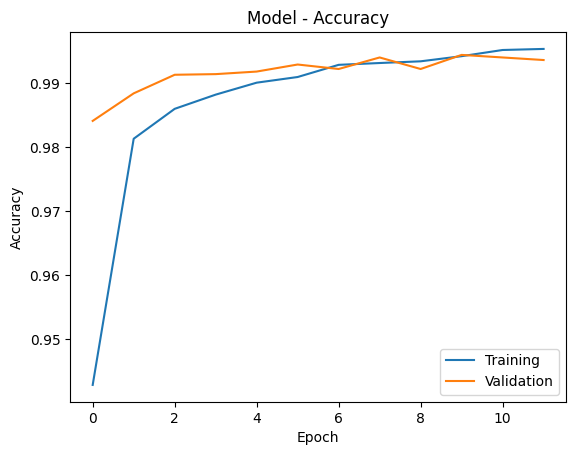

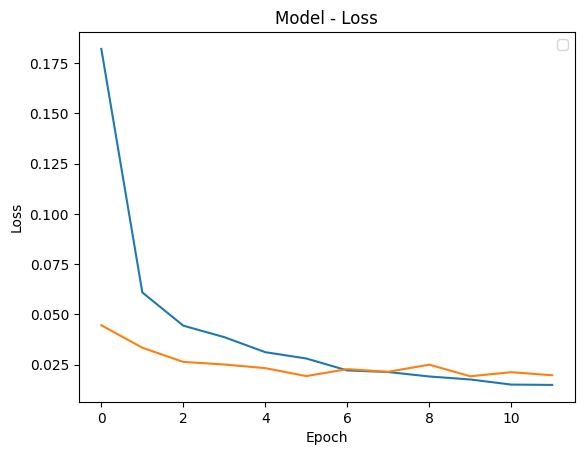

In [31]:
print(history)
fig1, ax_acc = plt.subplots()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model - Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()
fig2, ax_loss = plt.subplots()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model - Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

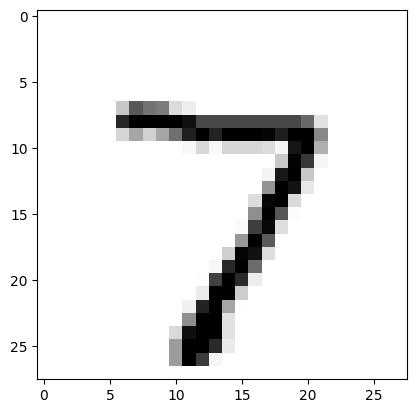

1/1 [==============================] - 0s 155ms/step
The Answer is  [[1.4342671e-13 6.4606535e-11 1.4491339e-11 2.5760290e-11 5.0214227e-13
  4.3641380e-12 4.3125101e-17 1.0000000e+00 1.0452651e-13 6.9636585e-10]]


In [32]:
n = 0
plt.imshow(x_test[n].reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()
print('The Answer is ', model.predict(x_test[n].reshape((1, 28, 28, 1))))